## Tuning the Deep Metric Model 

### Steps
1. Generate the embeddings for the training data
2. Tune the SVM classifier using grid search CV and Stratified Shuffling split on the training data
3. Visualize the embeddings using t-SNE
4. Evaluate on test data using the best model parameters.

In [69]:
from __future__ import division, print_function
import numpy as np
import tqdm
import pandas as pd

In [20]:
from Dataset import Dataset
from deep.FaceRecognizer import FaceRecognizer

In [21]:
dataset_path =  "/media/ankurrc/new_volume/softura/facerec/datasets/norm_cyber_extruder_ultimate"

### Generate the embeddings

In [22]:
recognizer_model = FaceRecognizer(
        model_path="deep/dlib_face_recognition_resnet_model_v1.dat",
        shape_predictor_path="deep/shape_predictor_5_face_landmarks.dat")
dataset = Dataset(dataset_path)

In [23]:
fold = 1
training_samples = 5

In [24]:
X_train, y_train, X_test, y_test = None, None, None, None
embeddings = None

In [26]:
print("Generating embeddings for", training_samples, " training samples per subject...")

X_train, y_train = dataset.load_data(is_train=True, fold=fold, num_train=training_samples)

print("(" + str(len(X_train)) + " samples and " + str(len(
np.unique(y_train))) + " subjects)")

embeddings = recognizer_model.embed(X_train)
        
print("done.")

Generating embeddings for 5  training samples per subject...
(3715 samples and 743 subjects)


done.


### Tune the SVM Classifier

In [33]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

In [51]:
dual = True # set false for att dataset
class_weight = "balanced" # set None for att dataset
Cs = np.logspace(-3, 10, 14, base=10.0)
n_jobs = 4

In [32]:
# refine the training data for tuning the classifier
X_train = np.array(embeddings)
y_train = LabelEncoder().fit_transform(y_train)

In [39]:
param_grid = dict(C=Cs)
cv = StratifiedShuffleSplit(n_splits=5,test_size=0.2, random_state=42)

In [40]:
clf = LinearSVC(dual=dual,class_weight=class_weight)

In [52]:
grid = GridSearchCV(clf, param_grid=param_grid, cv=cv, verbose=True, n_jobs=n_jobs)

In [53]:
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:  9.5min finished


The best parameters are {'C': 1.0} with a score of 0.98


In [71]:
grid_results = pd.DataFrame(data=grid.cv_results_)
grid_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,25.659353,0.043279,0.936743,0.986406,0.001,{u'C': 0.001},14,0.928668,0.986878,0.936743,...,0.935397,0.984859,0.936743,0.986541,0.946164,0.986541,0.782144,0.007843,0.005582,8.131256e-04
1,21.034760,0.038461,0.944549,0.989367,0.01,{u'C': 0.01},13,0.934051,0.990242,0.940781,...,0.950202,0.989233,0.946164,0.989233,0.951548,0.988560,1.566563,0.015789,0.006449,5.467051e-04
2,20.480795,0.029938,0.972005,0.996366,0.1,{u'C': 0.1},12,0.971736,0.996635,0.966353,...,0.975774,0.995962,0.973082,0.995962,0.973082,0.996972,0.572414,0.006862,0.003116,3.923925e-04
3,23.283659,0.026986,0.978735,0.999664,1,{u'C': 1.0},1,0.977120,0.999664,0.974428,...,0.982503,0.999664,0.979812,0.999664,0.979812,0.999664,0.972145,0.007851,0.002745,1.110223e-16
4,34.627690,0.039167,0.978197,1.000000,10,{u'C': 10.0},2,0.977120,1.000000,0.973082,...,0.981157,1.000000,0.978466,1.000000,0.981157,1.000000,2.713984,0.018270,0.002997,0.000000e+00
5,35.183213,0.031819,0.976043,1.000000,100,{u'C': 100.0},3,0.974428,1.000000,0.973082,...,0.979812,1.000000,0.974428,1.000000,0.978466,1.000000,3.370566,0.009494,0.002610,0.000000e+00
6,32.430448,0.023899,0.974966,1.000000,1000,{u'C': 1000.0},11,0.970390,1.000000,0.973082,...,0.981157,1.000000,0.974428,1.000000,0.975774,1.000000,4.238815,0.002286,0.003571,0.000000e+00
7,30.576229,0.028017,0.975236,1.000000,10000,{u'C': 10000.0},5,0.970390,1.000000,0.973082,...,0.981157,1.000000,0.974428,1.000000,0.977120,1.000000,0.125438,0.006291,0.003671,0.000000e+00
8,31.252567,0.022576,0.975505,1.000000,100000,{u'C': 100000.0},4,0.971736,1.000000,0.973082,...,0.981157,1.000000,0.974428,1.000000,0.977120,1.000000,0.653291,0.002641,0.003340,0.000000e+00
9,30.296240,0.032112,0.975236,1.000000,1e+06,{u'C': 1000000.0},5,0.970390,1.000000,0.973082,...,0.981157,1.000000,0.974428,1.000000,0.977120,1.000000,0.796844,0.019251,0.003671,0.000000e+00


### Evaluate the classifier

In [61]:
X_test, y_test = dataset.load_data(is_train=False, fold=fold, num_train=training_samples)

In [59]:
print("Generating 'test' embeddings for...")
print("(" + str(len(X_test)) + " samples and " + str(len(
np.unique(y_test))) + " subjects)")

test_embeddings = recognizer_model.embed(X_test)
        
print("done.")

Generating 'test' embeddings for...
(2349 samples and 743 subjects)


done.


In [62]:
X_test = np.array(test_embeddings)
y_test = LabelEncoder().fit_transform(y_test)

In [72]:
accuracy_score(y_test, grid.predict(X_test))

0.9821200510855683

### Train a novelty detector

In [85]:
from sklearn import svm

In [112]:
outliers_fraction = 0.001

In [121]:
novelty_clf = svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)

In [122]:
novelty_clf.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.001, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

### Evaluate the novelty detector

In [123]:
y_pred_train = novelty_clf.predict(X_train)

In [143]:
print("Error:", (y_pred_train[y_pred_train == -1].size/y_pred_train.size), "%")

Error: 0.00403768506057 %


In [125]:
y_pred_test = novelty_clf.predict(X_test)

In [144]:
print("Error:", (y_pred_test[y_pred_test == -1].size/y_pred_test.size), "%")

Error: 0.00936568752661 %


In [128]:
dataset_nd_path = "/media/ankurrc/new_volume/softura/facerec/datasets/norm_standard_att"
dataset_nd = Dataset(dataset_nd_path)

In [135]:
X_outlier, y_outlier = dataset_nd.load_data(is_train=False, fold=fold, num_train=2)

In [136]:
print("Generating 'oulier' embeddings for...")
print("(" + str(len(X_outlier)) + " samples and " + str(len(
np.unique(y_outlier))) + " subjects)")

outlier_embeddings = recognizer_model.embed(X_outlier)
        
print("done.")

Generating 'oulier' embeddings for...
(314 samples and 40 subjects)


done.


In [138]:
X_outlier = np.array(outlier_embeddings)

In [139]:
y_pred_outlier = novelty_clf.predict(X_outlier)

In [141]:
y_pred_outlier_error = y_pred_outlier[y_pred_outlier == 1].size

In [142]:
print("Error:", (y_pred_outlier_error/y_pred_outlier.size), "%")

Error: 1.0 %


### Save model 

In [78]:
import pickle as pkl
from sklearn.externals import joblib

In [ ]:
# save the classifier model
#joblib.dump(grid, "face_classifier.pkl")

In [ ]:
# save the embeddings with labels
#joblib.dump((embeddings, y_test), "train_embeddings.pkl")

In [ ]:
# save the novelty detector
#joblib.dump(grid, "novelty_dector.pkl")

### Visualizing the embeddings

In [145]:
from sklearn.manifold import TSNE

In [146]:
X_embedded = TSNE(n_components=2, verbose=True).fit_transform(X_train)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3715 samples in 0.021s...
[t-SNE] Computed neighbors for 3715 samples in 3.737s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3715
[t-SNE] Computed conditional probabilities for sample 2000 / 3715
[t-SNE] Computed conditional probabilities for sample 3000 / 3715
[t-SNE] Computed conditional probabilities for sample 3715 / 3715
[t-SNE] Mean sigma: 0.232304
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.852318
[t-SNE] Error after 1000 iterations: 1.413114


In [148]:
type(X_embedded)

numpy.ndarray

In [155]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(theme='onedork')
plt.rcParams['figure.figsize'] = [25, 15]

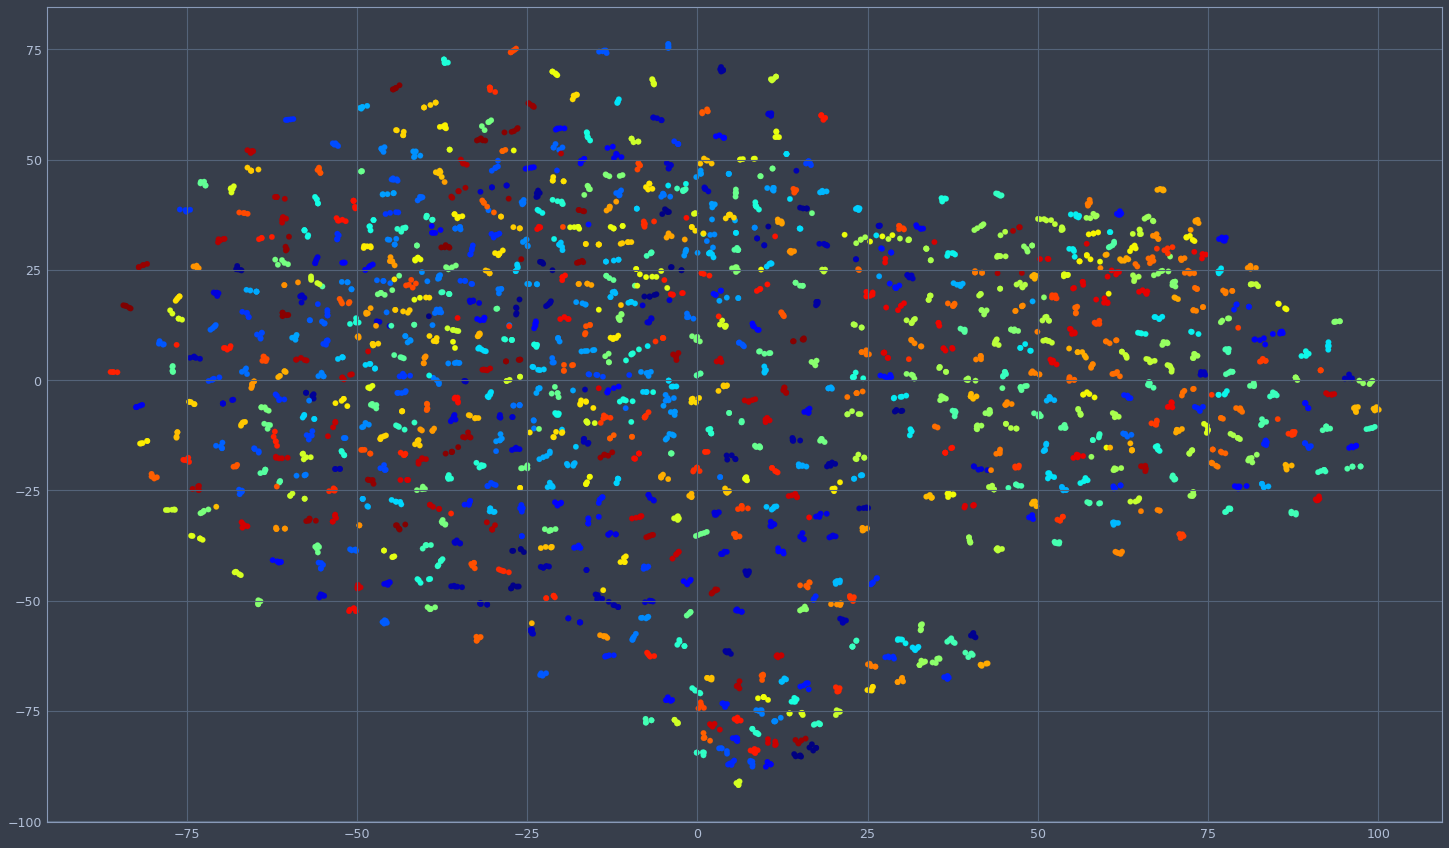

In [158]:
vis_x = X_embedded[:, 0]
vis_y = X_embedded[:, 1]
plt.scatter(vis_x, vis_y, c=y_train, cmap=plt.cm.get_cmap("jet", y_train.shape[0]))
#plt.colorbar(ticks=range(y_train.shape[0]))
#plt.clim(-0.5, 9.5)
plt.show()